In [27]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras import Sequential
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D,MaxPool2D, BatchNormalization, Dropout

In [2]:
# Copy the input_folder to the output in order to be able to balance your dataset 
# easily by deleting the images. You can use any approach to balance the dataset
!cp -r ../input/chest-xray-pneumonia/chest_xray/ ./

In [3]:
# Define directories
train_dir = './chest_xray/train'
valid_dir ='./chest_xray/val'
test_dir ='./chest_xray/test'

In [4]:
train_norm_count = [i for i in os.listdir(train_dir + '/NORMAL')]
train_pneu_count = [i for i in os.listdir(train_dir + '/PNEUMONIA')]

print(len(train_norm_count),'normal images',',',len(train_pneu_count),'pneumonia images')

1341 normal images 3875 pneumonia images


In [5]:
to_del = len(train_pneu_count)-len(train_norm_count)
# Balance the classes
for i in range(to_del):
    for i in os.listdir(train_dir + '/PNEUMONIA'):
        os.remove(train_dir + '/PNEUMONIA/'+i)
        break
        
train_norm_count = [i for i in os.listdir(train_dir + '/NORMAL')]
train_pneu_count = [i for i in os.listdir(train_dir + '/PNEUMONIA')]

print(len(train_norm_count),'normal images',',',len(train_pneu_count),'pneumonia images')

1341 normal images 1341 pneumonia images


In [6]:
# Validation images
val_norm_count = [i for i in os.listdir(valid_dir + '/NORMAL')]
val_pneu_count = [i for i in os.listdir(valid_dir + '/PNEUMONIA')]

print(len(val_norm_count),len(val_pneu_count))

8 8


In [7]:
# Test images
test_norm_count = [i for i in os.listdir(test_dir + '/NORMAL')]
test_pneu_count = [i for i in os.listdir(test_dir + '/PNEUMONIA')]

print(len(test_norm_count),len(test_pneu_count))

234 390


In [8]:
# Define image width, height and batch size
img_height = 150
img_width = 150
batch_size = 128

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=[0.05,-0.05],
                                   height_shift_range=[0.05,-0.05],
                                   shear_range=0.05,
                                  horizontal_flip=True,
                                  validation_split = 0.20) 

train_generator = train_datagen.flow_from_directory(
                                  train_dir,
                                  target_size=(img_height, img_width),
                                  batch_size=batch_size,
                                  subset ='training',
                                  class_mode='categorical',
                                  seed=42
                                  ) 

Found 2146 images belonging to 2 classes.


In [10]:
val_generator = train_datagen.flow_from_directory(
                                  train_dir,
                                  target_size=(img_height, img_width),
                                  batch_size=batch_size,
                                  subset ='validation',
                                  class_mode='categorical',
                                  seed=42) 

Found 536 images belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255) 
test_generator = test_datagen.flow_from_directory(
                                  test_dir,
                                  target_size=(img_height, img_width),
                                  batch_size=batch_size,
                                  class_mode='categorical',
                                  seed=42,
                                  shuffle=False) 

Found 624 images belonging to 2 classes.


In [12]:
def build_model():
    in_shape=(img_height, img_width, 3)
    out_shape=2

    model=Sequential()
    model.add(Conv2D(128,(3,3),activation='relu',input_shape=in_shape)),
    model.add(MaxPooling2D(pool_size=(2,2))),

    model.add(Conv2D(256,(3,3), activation='relu')),
    model.add(MaxPooling2D(pool_size=(2,2))),

    model.add(Conv2D(512,(3,3), activation='relu')),
    model.add(MaxPooling2D(pool_size=(2,2))),

    model.add(Conv2D(512,(3,3), activation='relu')),
    model.add(MaxPooling2D(pool_size=(2,2))),


    model.add(Flatten()),
    model.add(Dense(512, activation='relu')),
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy'])

    return model

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 512)       2

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy'])

In [16]:
#setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / test_generator.batch_size))

In [17]:
#modelcheckpoint is set to monitor the model using validation 
# val_accuracy score and save the best only
save_best_check_point = ModelCheckpoint(filepath = './best_model.hdf5', 
                                        monitor = 'val_accuracy',
                                        mode = 'max',
                                        save_best_only = True,
                                        save_weights_only = True)

In [18]:
history = model.fit(x = train_generator, 
           steps_per_epoch = step_train_size, 
           validation_data = val_generator, 
           validation_steps = step_val_size,epochs = 20, 
           callbacks = [save_best_check_point])

Epoch 1/20
17/17 [==============================] - 56s 3s/step - loss: 0.7107 - accuracy: 0.5029 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 2/20
17/17 [==============================] - 49s 3s/step - loss: 0.6818 - accuracy: 0.5795 - val_loss: 0.5705 - val_accuracy: 0.8022
Epoch 3/20
17/17 [==============================] - 49s 3s/step - loss: 0.6993 - accuracy: 0.6269 - val_loss: 0.8234 - val_accuracy: 0.5019
Epoch 4/20
17/17 [==============================] - 49s 3s/step - loss: 0.6130 - accuracy: 0.6928 - val_loss: 0.7327 - val_accuracy: 0.6623
Epoch 5/20
17/17 [==============================] - 49s 3s/step - loss: 0.5448 - accuracy: 0.7572 - val_loss: 0.5133 - val_accuracy: 0.7892
Epoch 6/20
17/17 [==============================] - 49s 3s/step - loss: 0.5006 - accuracy: 0.7858 - val_loss: 0.3890 - val_accuracy: 0.8302
Epoch 7/20
17/17 [==============================] - 49s 3s/step - loss: 0.3544 - accuracy: 0.8550 - val_loss: 0.2745 - val_accuracy: 0.8843
Epoch 8/20
17/17 [==

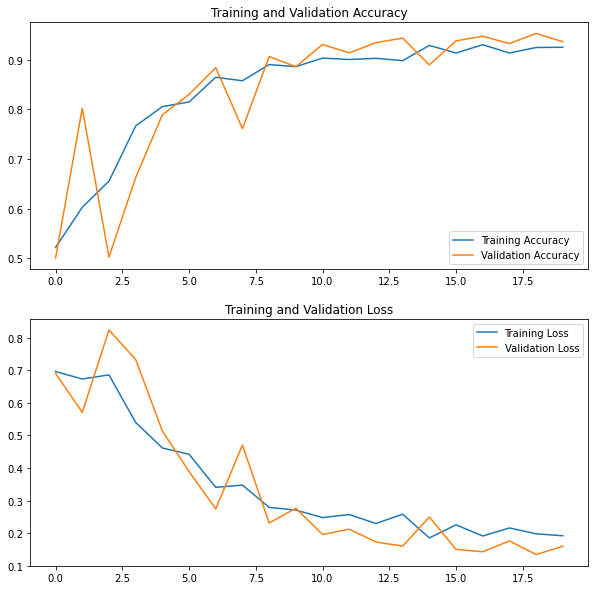

In [19]:
# Plot training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model_best = build_model()

In [21]:
model_best.load_weights('./best_model.hdf5')

In [22]:
import cv2
# Preparing test data
normal_cases_dir = test_dir + '/NORMAL'
pneumonia_cases_dir = test_dir +  '/PNEUMONIA'


In [23]:
normal_cases = [i for i in os.listdir(normal_cases_dir)]
pneumonia_cases = [i for i in os.listdir(pneumonia_cases_dir)]

In [24]:
test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(f'{normal_cases_dir}/{img}')
    img = cv2.resize(img, (img_height,img_width))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(f'{pneumonia_cases_dir}/{img}')
    img = cv2.resize(img, (img_height,img_width))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 150, 150, 3)
Total number of labels: (624, 2)


## Get predictions with model

In [42]:
preds = model.predict(test_data, batch_size=128)
preds = np.argmax(preds, axis=-1)
# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
print(cm)
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
print('')
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

[[181  53]
 [ 20 370]]

Recall of the model is 0.95
Precision of the model is 0.87


In [46]:
predictions = model.predict_generator(test_generator, steps=10)
predicted_classes = np.argmax(predictions, axis=1) 

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  

from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.91      0.77      0.83       234
   PNEUMONIA       0.88      0.95      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.89      0.88      0.88       624



The above model is obviously the best for predicting pneumonia with a 

recall of 0.95 and 
precision of 0.88 

as compared to the one below having 

recall of 0.97 and 
precision of 0.80

## Get predictions with best model saved based on best val_accuracy

In [43]:
preds = model_best.predict(test_data, batch_size=128)
preds = np.argmax(preds, axis=-1)
# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
print(cm)
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
print('')
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

[[141  93]
 [ 12 378]]

Recall of the model is 0.97
Precision of the model is 0.80


In [44]:
predictions = model_best.predict_generator(test_generator, steps=10)
predicted_classes = np.argmax(predictions, axis=1) 

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  

from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.93      0.59      0.72       234
   PNEUMONIA       0.80      0.97      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.78      0.80       624
weighted avg       0.85      0.83      0.82       624

